# 1. Modeling of carbon cycle

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# 提取gamma的数值
df_emission = pd.read_csv('global.1751_2014.ems', sep='\s+', skiprows=33).iloc[:,0:2]
df_emission.set_index('Year', inplace=True)
## Total: Total CO2 emissions from fossil-fuels and cement production (million metric tons of carbon)

## 单位换算 ppm = million metric tons of carbon * 1e-3 / 2.13
df_emission = df_emission * 1e-3 / 2.13# 单位为ppm
df_emission

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\perha\AppData\Local\Temp\ipykernel_20916\3923548370.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_emission = pd.read_csv('global.1751_2014.ems', sep='\s+', skiprows=33).iloc[:,0:2]


,Total
Year,
1751,0.001408
1752,0.001408
1753,0.001408
1754,0.001408
1755,0.001408
...,...
2010,4.285446
2011,4.461502
2012,4.541315


In [4]:
# 提取 Mauna Loa 站点的观测值
ML_observations = pd.read_csv('co2_annmean_mlo.csv', skiprows=43).iloc[:,0:2]
ML_observations.rename(columns={'year': 'Year', 'mean': 'Obs'}, inplace=True)
ML_observations.set_index('Year', inplace=True)
ML_observations.loc[1986:2004] # 单位为ppm

,Obs
Year,
1986,347.61
1987,349.31
1988,351.69
1989,353.20
1990,354.45
1991,355.70
1992,356.54
1993,357.21
1994,358.96


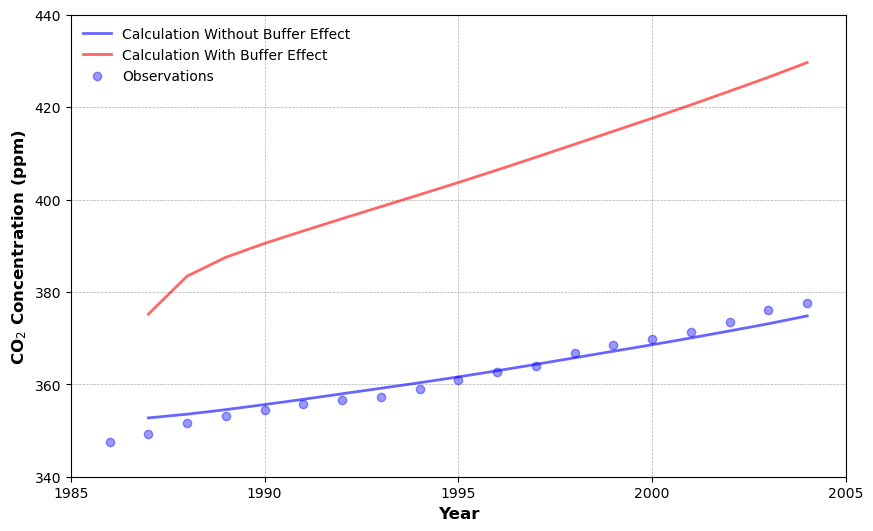

In [5]:
# 1.1 
## 定义无缓冲效应的模型
def model_no_buffer(N, t, k12, k21, gamma_t):
    N1, N2 = N
    dN1_dt = -k12 * N1 + k21 * N2 + gamma_t
    dN2_dt = k12 * N1 - k21 * N2
    return [dN1_dt, dN2_dt]

# 1.2 
## 定义有缓冲效应的模型
def model_with_buffer(N, t, k12, k21, gamma_t, N2_pre):
    N1, N2 = N
    ### 计算缓冲因子，采用估计值（公式A9）： xi = 3.69 + 1.86 * 10**(-2) * z - 1.80 * 10**(-6) * z**2
    xi = 3.69 + 1.86 * 10**(-2) * N1 - 1.80 * 10**(-6) * N1**2
    dN1_dt = -k12 * N1 + k21 * (N2_pre + xi * (N2 - N2_pre)) + gamma_t
    dN2_dt = k12 * N1 - k21 * (N2_pre + xi * (N2 - N2_pre))
    return [dN1_dt, dN2_dt]

# 1.3
## 定义 transfer coefficients 参数
k12 = 105 / 740
k21 = 102 / 900

## 初始条件
N1_0 = 750 / 2.13 # 1987年大气中的碳浓度，单位ppm
N2_0 = 900 / 2.13 # 1987年海洋表面的碳浓度，单位ppm
N2_pre_ppm = 821 / 2.13 # 单位ppm
## 时间跨度
year = np.arange(1986, 2004, 1) #  计算从 1987 to 2004 年的数据, 根据2003年计算2004年数据，因此截至至2003
## 存放模型计算结果
N_no_buffer = np.zeros((len(year)+1, 2))
N_with_buffer = np.zeros((len(year)+1, 2))
N_no_buffer[0] = [N1_0, N2_0] 
N_with_buffer[0] = [N1_0, N2_0]

## 解微分方程
### 由于 gamma 为时间的变量，因此需遍历时间 t，找到当年的 gamma（释放的CO2）
for t in year:  # 最后一年数据为前一年计算得到，因此 t 遍历至最后一年的前一年即可
    ### 找到 gamma 值
    gamma = df_emission.loc[t,'Total']
    N_no_buffer[t+1-year[0]] = odeint(model_no_buffer,
                                      N_no_buffer[t-year[0]],
                                      np.array([t,t+1]),
                                      args=(k12, k21, gamma))[-1]
    N_with_buffer[t+1-year[0]] = odeint(model_with_buffer,
                                        N_with_buffer[t-year[0]],
                                        np.array([t,t+1]),
                                        args=(k12, k21, gamma, N2_pre_ppm))[-1]

## 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(year+1, N_no_buffer[1:, 0], label='Calculation Without Buffer Effect', color='blue', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(year+1, N_with_buffer[1:, 0], label='Calculation With Buffer Effect', color='red', linestyle='-', linewidth=2, alpha=0.6)
plt.scatter(ML_observations.loc[1986:2004].index, ML_observations.loc[1986:2004].values, color='blue', label='Observations', zorder=3, alpha=0.4)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('CO$_2$ Concentration (ppm)', fontsize=12, fontweight='bold')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', frameon=False)

plt.xticks(np.arange(1985, 2008, 5), fontsize=10)
plt.yticks(np.arange(340, 441, 20), fontsize=10)

plt.show()

## Bonus

In [7]:
# delta：The emission of CO2 by changes in land use
## 如果读取不了则需要：pip install xlrd
delta_after_1850 = pd.read_excel('Global_land-use_flux-1850_2005.xls').iloc[:,0:2] # 单位 Tg
delta_after_1850.set_index('Year', inplace=True)

## 1750~1850 年的数据由 1750年的200TgC ~ 1850年的500.6TgC线性插值作估计 
delta_before_1850 = pd.DataFrame({'Year':range(1750, 1850),
                                  'Global':[(200 + (x - 1750) * (500.6 - 200) / (1850 - 1750)) for x in range(1750,1850)]})
delta_before_1850.set_index('Year', inplace=True)

## 合并数据
delta = pd.concat([delta_before_1850, delta_after_1850], axis=0)
## 向大气和土壤各传输一半，并换算单位为ppm(ppm=TgC/1000/2.13)
delta = delta / 2 / 1000 / 2.13
delta # 单位ppm

,Global
Year,
1750,0.046948
1751,0.047654
1752,0.048360
1753,0.049065
1754,0.049771
...,...
2001,0.325211
2002,0.356268
2003,0.355211


In [8]:
# Obeservation：数据由 ice cores from Antarctica until 1960 和 Mauna Loa after 1960 组成
## 读取 ice cores from Antarctica until 1960 的数据
ice_core_observations = pd.read_csv('lawdome.smoothed.yr75', sep='\s+', skiprows=21, names=['Year','Obs']) # 单位ppm
ice_core_observations.set_index('Year',inplace=True)

## 合并 Obeservation 的数据
Oberservations_T = pd.concat([ice_core_observations.loc[1010:1955],ML_observations.loc[1960:]], axis=0)
Oberservations_T # 单位 ppm

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\perha\AppData\Local\Temp\ipykernel_20916\2784917974.py:3: SyntaxWarning: invalid escape sequence '\s'
  ice_core_observations = pd.read_csv('lawdome.smoothed.yr75', sep='\s+', skiprows=21, names=['Year','Obs']) # 单位ppm


,Obs
Year,
1010,279.50
1015,279.60
1020,279.70
1025,279.80
1030,279.90
...,...
2019,411.65
2020,414.21
2021,416.41


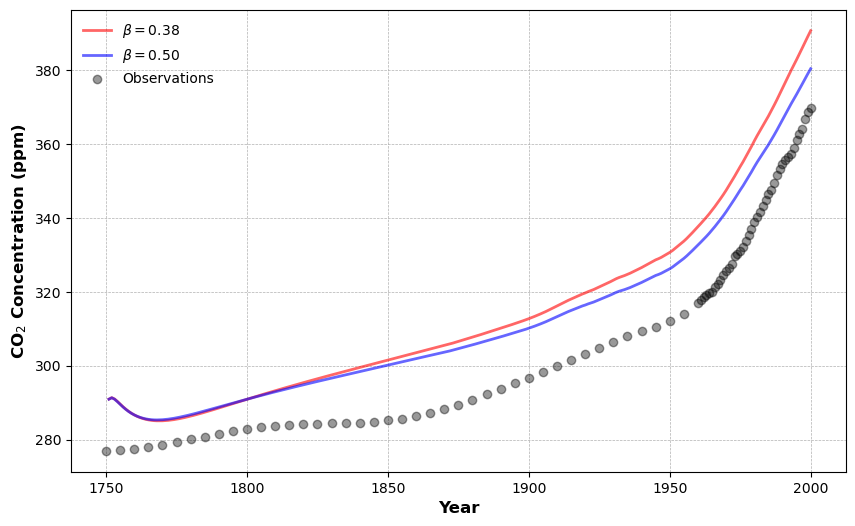

In [9]:
# 定义 transfer coefficients 参数
k12 = 60 / 615
k21 = 60 / 842
k23 = 9 / 842
k24 = 43 / 842
k32 = 52 / 9744
k34 = 162 / 9744
k43 = 205 / 26280
k45 = 0.2 / 26280
k51 = 0.2 / 90000000
k67 = 62 / 731
k71 = 62 / 1328

# 定义 seven-box 模型函数
def model_seven_box(N, t, N2_pre, gamma_t, beta, f0, P0, delta):
    N1, N2, N3, N4, N5, N6, N7 = N
    ## 计算缓冲因子，采用估计值（公式A9）： xi = 3.69 + 1.86 * 10**(-2) * z - 1.80 * 10**(-6) * z**2
    xi = 3.69 + 1.86 * 10**(-2) * N1 - 1.80 * 10**(-6) * N1**2
    ## 计算f
    f = f0 * (1 + beta * math.log(N1 / P0))
    dN1_dt = - k12 * N1 + k21 * (N2_pre + xi * (N2 - N2_pre)) + gamma_t - f + delta + k51 * N5 + k71 * N7
    dN2_dt = k12 * N1 - k21 * (N2_pre + xi * (N2 - N2_pre)) - k23 * N2 + k32 * N3 - k24 * N2
    dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
    dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
    dN5_dt = k45 * N4 - k51 * N5
    dN6_dt = f - k67 * N6 - 2 * delta
    dN7_dt = k67 * N6 - k71 * N7 + delta
    return [dN1_dt, dN2_dt, dN3_dt, dN4_dt, dN5_dt, dN6_dt, dN7_dt]

# 初始条件
N_initial = [615, 842, 9744, 26280, 90000000, 731, 1238] # 输入的初始条件，单位PgC
N_initial = [ x/2.13 for x in N_initial ] # 单位换算成ppm

# 时间跨度
year = np.arange(1750, 2000, 1) #  计算从 1750 to 2000 年的数据, 根据1999年计算2000年数据，因此截至1999
# 存放模型计算结果
N_seven_beta38 = np.zeros((len(year)+1, 7))
N_seven_beta38[0] = N_initial
N_seven_beta50 = np.zeros((len(year)+1, 7))
N_seven_beta50[0] = N_initial

# 解微分方程
## 由于 gamma 为时间的变量，因此需遍历时间 t，找到当年的 gamma（释放的CO2）
for t in year:  # 最后一年数据为前一年计算得到，因此 t 遍历至最后一年的前一年即可
    ## 找到 gamma 值
    if t==1750: # 缺失1750年的数值，用1751年的数值代替
        gamma = df_emission.loc[1751,'Total'] # 单位ppm
    else:
        gamma = (df_emission.loc[t,'Total'])  # 单位ppm
    N_seven_beta38[t+1-year[0]] = odeint(model_seven_box,
                                  N_seven_beta38[t-year[0]],
                                  np.array([t,t+1]),
                                  args=(821/2.13, gamma, 0.38, 62/2.13, 289, delta.loc[t,'Global'])
                                 )[-1] # 取t+1的结果
    N_seven_beta50[t+1-year[0]] = odeint(model_seven_box,
                                  N_seven_beta50[t-year[0]],
                                  np.array([t,t+1]),
                                  args=(821/2.13, gamma, 0.50, 62/2.13, 289, delta.loc[t,'Global'])
                                 )[-1] # 取t+1的结果

## 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(year+1, N_seven_beta38[1:, 0], label=r'$\beta = 0.38$', color='red', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(year+1, N_seven_beta50[1:, 0], label=r'$\beta = 0.50$', color='blue', linestyle='-', linewidth=2, alpha=0.6)
plt.scatter(Oberservations_T.loc[1750:2000].index, Oberservations_T.loc[1750:2000].values, color='black', label='Observations', zorder=3, alpha=0.4)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('CO$_2$ Concentration (ppm)', fontsize=12, fontweight='bold')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', frameon=False)

plt.show()